In [39]:
import pandas as pd
import pickle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Conv1D, MaxPooling1D

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import logging
logging.basicConfig(level=logging.INFO)

In [7]:
df = pd.read_csv("./../Data/preprocessed_train_data.csv")
df.head()

,Unnamed: 0,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,0,1,ten best stat nobody ev com clos elev walk roo...,1,2.42,1.0,0.2
1,1,2,man insert advert class wif want next day rece...,1,2.50,1.0,1.1
2,2,3,many men tak op beer non op tim bring couch,1,1.95,0.0,2.4
3,3,4,tell mom hit 1200 twit follow point broth own ...,1,2.11,1.0,0.0
4,4,5,ros dead lov fak wed bas fun cak,1,2.78,0.0,0.1


In [12]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("./../Data/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)

In [13]:
## Check function
x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
x_test_sample = ["I’m creating a macro and need some text for testing purposes", "I’m designing a document and don’t want to get bogged down in what the text actually says"]
X_train_Glove_s, X_test_Glove_s, word_index_s, embeddings_dict_s = prepare_model_input(x_train_sample, x_test_sample, 100, 20)
print("\n X_train_Glove_s \n ", X_train_Glove_s)
print("\n X_test_Glove_s \n ", X_test_Glove_s)
print("\n Word index of the word testing is : ", word_index_s["testing"])
print("\n Embedding for the word want \n \n", embeddings_dict_s["want"])

Found 51 unique tokens.
(4, 20)
Total 400000 word vectors.

 X_train_Glove_s 
  [[ 0  0  0  0  0  0  0  0  8  9  5 10 11  2  6  3 12  4 13 14]
 [17 18 19  1 20 21 22 23 24  3 25 26  6  1 27 28 29 30 31 32]]

 X_test_Glove_s 
  [[ 0  0  0  0  0  0  0  0  0  7 33  1 34  4 35 36  2 37 38 39]
 [ 0  0  0  7 40  1 41  4 42 43 44 45 46 47 48 49  3  2 50 51]]

 Word index of the word testing is :  38

 Embedding for thw word want 
 
 [ 0.13627  -0.054478  0.3703   -0.41574   0.60568  -0.42729  -0.50151
  0.35923  -0.49154   0.21827  -0.15193   0.52536  -0.24206   0.023875
  0.8225    1.089     0.98825  -0.17803   0.77806  -1.0647   -0.28742
  0.50458   0.21612   0.65681   0.34295  -2.1084   -0.82557  -0.31966
  0.87567  -1.0679    3.3802    1.2084   -1.272    -0.15921  -0.25237
 -0.2696   -0.18756  -0.35523   0.084172 -0.56539  -0.24081   0.15926
  0.3287    0.54591   0.29897   0.18948  -0.57113   0.17399  -0.19338
  0.51921 ]


In [29]:
def build_cnn(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # create model
    model_glove = Sequential()
    # Add embedding layer
    model_glove.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))    
    model_glove.add(Dropout(dropout))
    model_glove.add(Conv1D(64, 5, activation='relu'))
    model_glove.add(MaxPooling1D(pool_size=4))
    model_glove.add(LSTM(100))
    model_glove.add(Dense(1, activation='sigmoid'))
    model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_glove


In [30]:
X = df.text.astype(str)
y = df.is_humor.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_cnn(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 9136 unique tokens.
(8000, 500)
Total 400000 word vectors.
Done!
Building Model!
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 50)           456850    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 496, 64)           16064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total p

In [31]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [32]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=5,
                           batch_size=128,
                           verbose=1)


Train on 6400 samples, validate on 1600 samples
Epoch 1/5
6400/6400 [==============================] - 12s 2ms/step - loss: 0.6604 - accuracy: 0.6073 - val_loss: 0.6346 - val_accuracy: 0.6263
Epoch 2/5
6400/6400 [==============================] - 11s 2ms/step - loss: 0.6009 - accuracy: 0.6758 - val_loss: 0.5597 - val_accuracy: 0.7063
Epoch 3/5
6400/6400 [==============================] - 11s 2ms/step - loss: 0.5417 - accuracy: 0.7237 - val_loss: 0.5296 - val_accuracy: 0.7281
Epoch 4/5
6400/6400 [==============================] - 11s 2ms/step - loss: 0.4925 - accuracy: 0.7717 - val_loss: 0.4663 - val_accuracy: 0.7894
Epoch 5/5
6400/6400 [==============================] - 11s 2ms/step - loss: 0.4571 - accuracy: 0.7841 - val_loss: 0.4554 - val_accuracy: 0.7937


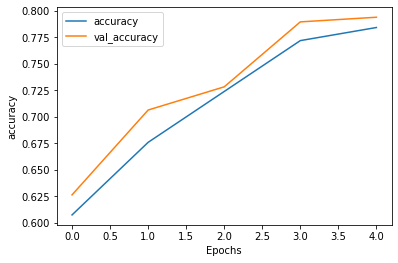

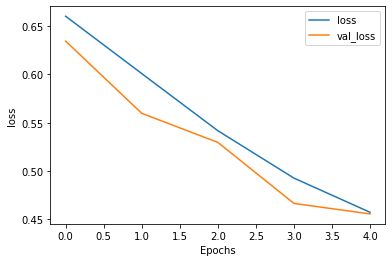

In [35]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [42]:
print("\n Evaluating Model ... \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test.astype(str), predicted.astype(str)))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test.astype(str), predicted.astype(str))
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 



INFO:logger:  mcc = 0.5564582911638106
INFO:logger:  true positive = 912
INFO:logger:  true negative = 358
INFO:logger:  false positive = 256
INFO:logger:  false negative = 74
INFO:logger:  pricision = 0.7808219178082192
INFO:logger:  recall = 0.9249492900608519
INFO:logger:  F1 = 0.8467966573816155
INFO:logger:  accuracy = 0.79375


              precision    recall  f1-score   support

           0       0.83      0.58      0.68       614
           1       0.78      0.92      0.85       986

    accuracy                           0.79      1600
   macro avg       0.80      0.75      0.77      1600
weighted avg       0.80      0.79      0.78      1600



